In [4]:

import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ".." signifie "remonter d'un dossier"
sys.path.append(os.path.abspath('..'))

# Importation du module
from src.data_loader import DataLoader

# Configuration du style des graphiques
%matplotlib inline
sns.set_theme(style="whitegrid") # Un style propre pour les rapports
plt.rcParams['figure.figsize'] = (12, 6) # Taille par défaut des images

In [ ]:

import sys
import os
sys.path.append(os.path.abspath('..'))
from src.data_loader import DataLoader

# 1. Définition des paramètres
TICKERS = ['AAPL', 'JPM', 'XOM', 'TLT']
START_DATE = "2020-01-01"
END_DATE = "2025-12-31"

# 2. Instanciation du loader et Téléchargement
loader = DataLoader(TICKERS, START_DATE, END_DATE)
data = loader.get_data()

# 3. Affichage pour vérification
print("\n--- Aperçu des données ---")
display(data.head())

# 4. SAUVEGARDE (La partie importante)
# On crée le dossier s'il n'existe pas
os.makedirs('../data/raw', exist_ok=True)

# On sauvegarde en CSV
csv_path = '../data/raw/market_data.csv'
data.to_csv(csv_path)

print(f"\n✅ Données sauvegardées dans : {csv_path}")

Chargement des données pour ['AAPL', 'JPM', 'XOM', 'TLT']...


[*********************100%***********************]  4 of 4 completed


--- Aperçu des données ---


Ticker,AAPL,JPM,TLT,XOM
Date,,,,
2020-01-02,72.468262,119.036400,115.443710,53.661724
2020-01-03,71.763748,117.465576,117.221573,53.230297
2020-01-06,72.335556,117.372154,116.555916,53.639008
2020-01-07,71.995354,115.376762,115.982979,53.200027
2020-01-08,73.153488,116.276825,115.216240,52.397758



✅ Données sauvegardées dans : ../data/raw/market_data.csv


✅ Image sauvegardée avec succès : ../Graphiques/performance_history.png


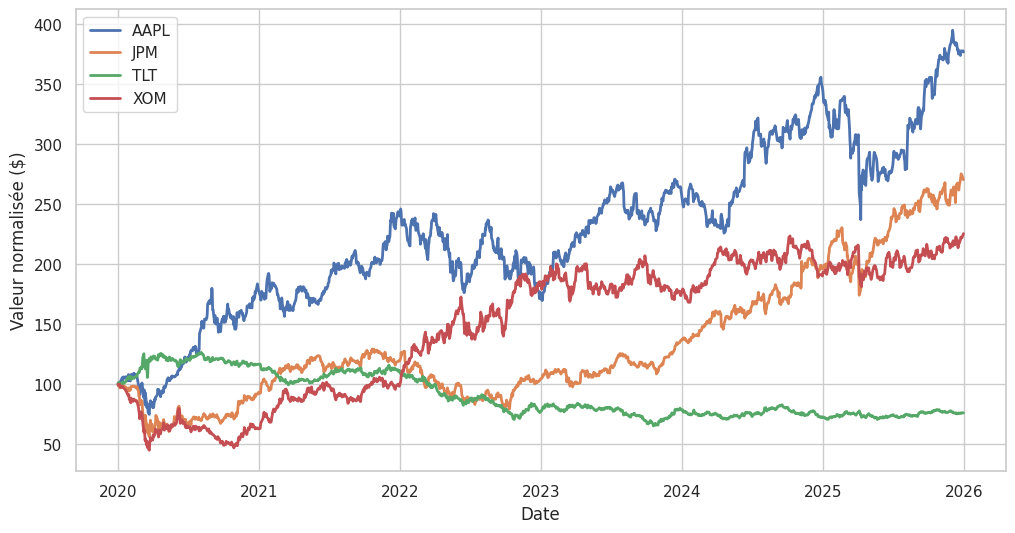

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Configuration du style (Optionnel mais plus joli pour le rapport)
sns.set_theme(style="whitegrid") # Ajoute une grille propre

# 2. Normalisation Base 100
data_normalized = (data / data.iloc[0]) * 100

# 3. Création du graphique
plt.figure(figsize=(12, 6))

# On trace les courbes
for column in data_normalized.columns:
    plt.plot(data_normalized.index, data_normalized[column], label=column, linewidth=2)

#plt.title("Performance relative des actifs (Base 100)", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Valeur normalisée ($)")
plt.legend(loc="upper left")

# --- PARTIE CRITIQUE : SAUVEGARDE AVANT AFFICHAGE ---
# On s'assure que le dossier 'Graphiques' existe
save_dir = '../Graphiques'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# On définit le chemin
save_path = os.path.join(save_dir, 'performance_history.png') # J'ai mis le nom utilisé dans le LaTeX

# ON SAUVEGARDE MAINTENANT !
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Image sauvegardée avec succès : {save_path}")

# --- ET ENFIN ON AFFICHE ---
plt.show()

✅ Image sauvegardée ici : ../Graphiques/correlation_matrix.png


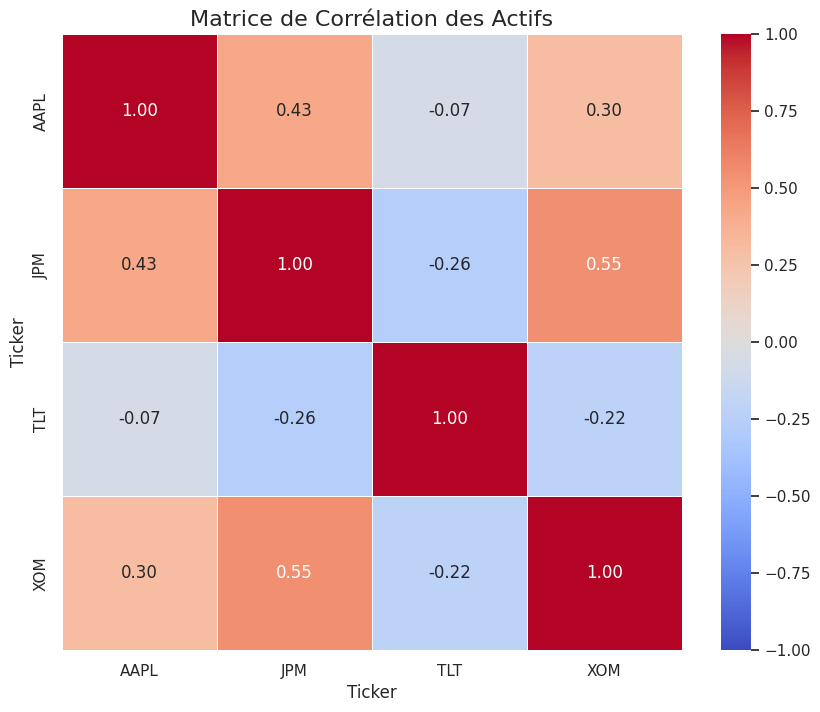

In [12]:
# --- CELLULE HEATMAP AVEC SAUVEGARDE ---
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Calcul des rendements et corrélation
returns = loader.calculate_returns(data)
corr_matrix = returns.corr()

# 2. Création de la figure
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,           # Affiche les chiffres
            cmap='coolwarm',      # Bleu à Rouge
            vmin=-1, vmax=1,      # Bornes de -1 à 1
            linewidths=0.5, 
            fmt=".2f")            # 2 chiffres après la virgule

plt.title("Matrice de Corrélation des Actifs", fontsize=16)

# 3. SAUVEGARDE DE L'IMAGE
# On s'assure que le dossier 'Graphiques' existe à la racine (ou adapte le chemin)
save_dir = '../Graphiques' # Le ".." remonte d'un cran si tu es dans le dossier notebooks
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# On sauvegarde en haute qualité (dpi=300)
save_path = os.path.join(save_dir, 'correlation_matrix.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"✅ Image sauvegardée ici : {save_path}")

# 4. Affichage
plt.show()

✅ Image sauvegardée ici : ../Graphiques/correlation_matrix.png


<Figure size 1200x600 with 0 Axes>

[                       0%                       ]

Téléchargement des données en cours...


[*********************100%***********************]  4 of 4 completed


✅ Données récupérées et nettoyées.

--- Allocation du Portefeuille ---
        weights
Ticker         
AAPL        0.4
JPM         0.2
TLT         0.2
XOM         0.2


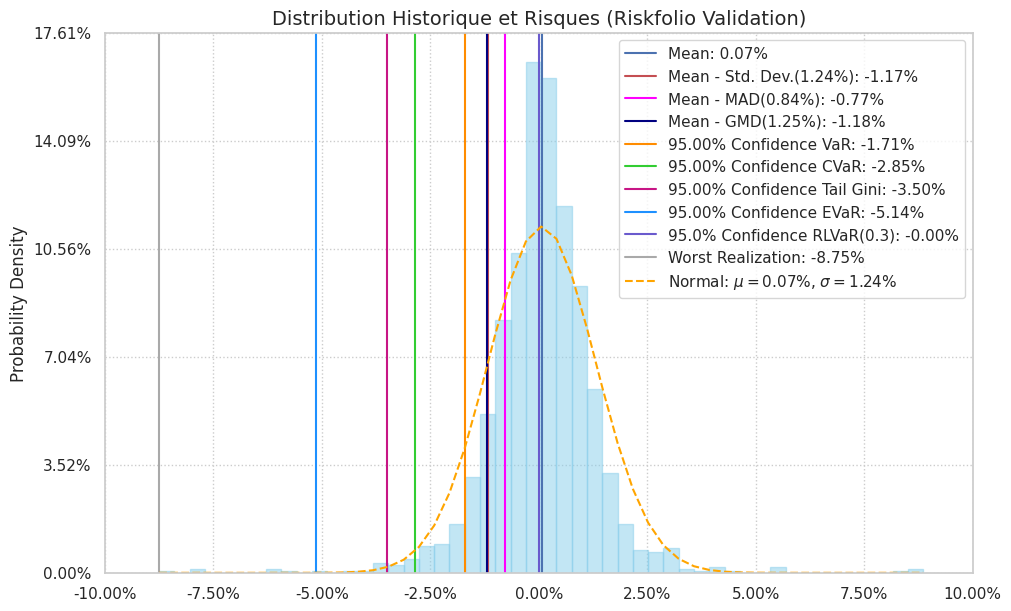


--- Validation des Chiffres (Riskfolio) ---
VaR 95% (Historique)  : 1.71%
CVaR 95% (Historique) : 2.85%


In [24]:
import riskfolio as rp
import yfinance as yf
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --- 1. TÉLÉCHARGEMENT ROBUSTE DES DONNÉES ---
tickers = ['AAPL', 'JPM', 'XOM', 'TLT']
start = '2020-01-01'
end = '2025-12-31'

print("Téléchargement des données en cours...")
raw_data = yf.download(tickers, start=start, end=end)

# Gestion intelligente des colonnes (pour éviter les erreurs yfinance)
if 'Adj Close' in raw_data.columns:
    data = raw_data['Adj Close']
elif 'Close' in raw_data.columns:
    data = raw_data['Close']
else:
    # Cas où yfinance renvoie un MultiIndex complexe
    try:
        data = raw_data.xs('Adj Close', level=0, axis=1)
    except KeyError:
        data = raw_data.xs('Close', level=0, axis=1)

# Calcul des rendements
returns = data.pct_change().dropna()
print("✅ Données récupérées et nettoyées.")

# --- 2. INITIALISATION DU PORTEFEUILLE ---
port = rp.Portfolio(returns=returns)

# On estime les paramètres statistiques (nécessaire pour certains calculs internes)
method_mu = 'hist' 
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# --- 3. DÉFINITION DE TES POIDS MANUELS ---
# Allocation forcée : 40% AAPL, 20% JPM, 20% XOM, 20% TLT
my_weights = pd.DataFrame(
    data=[0.40, 0.20, 0.20, 0.20], 
    index=['AAPL', 'JPM', 'XOM', 'TLT'], 
    columns=['weights']
)

# On s'assure que l'ordre des poids correspond à l'ordre des colonnes de rendements
my_weights = my_weights.reindex(returns.columns)

print("\n--- Allocation du Portefeuille ---")
print(my_weights)

# --- 4. GRAPHIQUE DE DISTRIBUTION ---
# Affiche la distribution historique, la VaR et la CVaR visuellement
plt.figure(figsize=(10,6))
# Riskfolio gère le calcul interne pour le graphique
ax = rp.plot_hist(returns=returns, w=my_weights, alpha=0.05)
plt.title("Distribution Historique et Risques (Riskfolio Validation)", fontsize=14)
plt.show()

# --- 5. CALCULS PRÉCIS (CORRIGÉ FINAL) ---
print("\n--- Validation des Chiffres (Riskfolio) ---")

# Calcul des rendements du portefeuille
port_returns = returns @ my_weights

# Calcul VaR et CVaR
var_val = rp.VaR_Hist(port_returns, alpha=0.05)
cvar_val = rp.CVaR_Hist(port_returns, alpha=0.05)

# CORRECTION : On enlève .item() car var_val est déjà un nombre (float)
print(f"VaR 95% (Historique)  : {var_val:.2%}")
print(f"CVaR 95% (Historique) : {cvar_val:.2%}")



In [20]:
!pip install riskfolio-lib

  Using cached riskfolio_lib-7.2.0-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (18 kB)
  Using cached clarabel-0.11.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
  Using cached scs-3.2.11-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (2.8 kB)
  Using cached cvxpy-1.7.5-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached arch-8.0.0-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached xlsxwriter-3.2.9-py3-none-any.whl.metadata (2.7 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached astropy-7.2.0-cp311-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (10 kB)
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
  Using cached vectorbt-0.28.2-py3-none-any.whl.metadata (12 kB)
  Using cached pyerfa-2.0.1.5-cp39-abi3-manylinux_2_17_x86_6